<a href="https://colab.research.google.com/github/AshiqAbdulkhader/Stock-Prediction/blob/main/Knowledge_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

# Data

In [4]:
data = pd.read_csv("Google_dataset.csv")
data.shape

(2006, 4)

# Entities extraction

In [5]:
def get_entities(sent):

  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    
  prv_tok_text = ""   

  prefix = ""
  modifier = ""


  
  for tok in nlp(sent):

    if tok.dep_ != "punct":

      if tok.dep_ == "compound":
        prefix = tok.text

        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text

        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      

      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      


      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
  
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [6]:
entity_pairs = []

for i in tqdm(data["Title"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 2006/2006 [00:24<00:00, 82.21it/s]


In [7]:
entity_pairs[:10]

[['Inflation report', 'stocks'],
 ['ahead  U.S.', 'customer info'],
 ['AMD', 'bigger  Intel'],
 ['', 'big summer Maxim'],
 ['MySpace hype', 'hybrid  credit'],
 ['AMD Citigroup', 'price target'],
 ['', ''],
 ['Why  Ballmer', 'Microsoft'],
 ['Security stocks', 'secure Growth Google'],
 ['Executive', 'guilty bribery rally']]

#  Relations Extraction

In [8]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [9]:
relations = [get_relation(i) for i in tqdm(data['Title'])]

100%|██████████| 2006/2006 [00:22<00:00, 89.38it/s]


# Build Knowledge Graph

In [10]:
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [11]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

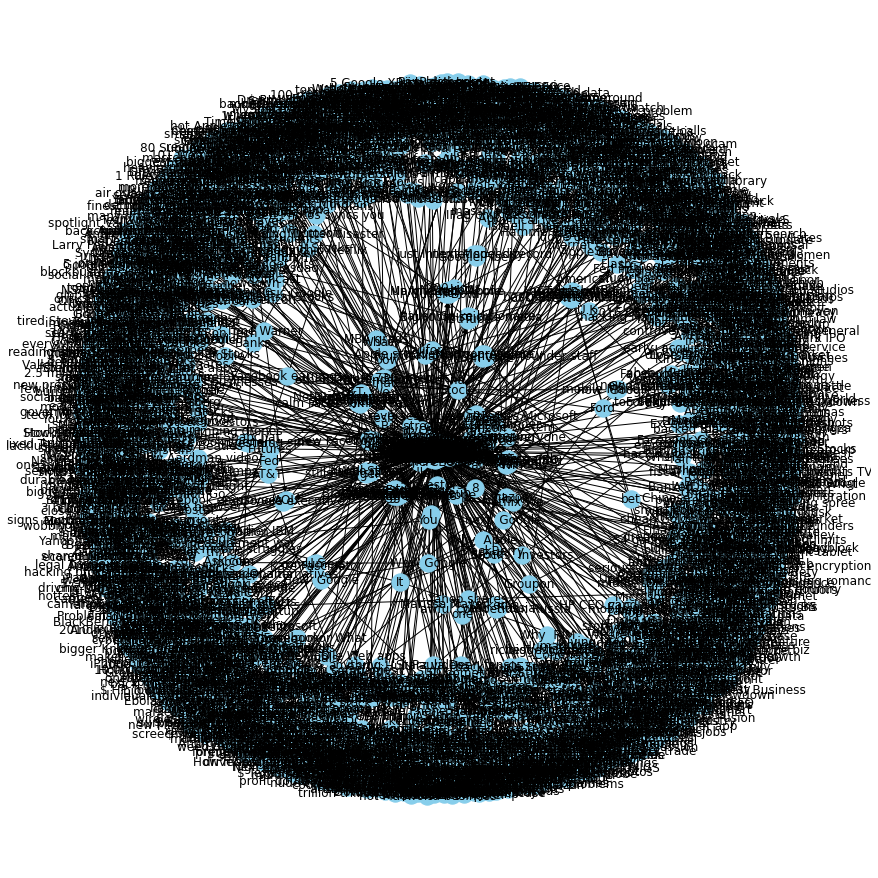

In [12]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()